# Fine-tuning ESM2 on promiscuous esterases

In [1]:
# Import dependencies
import torch
from transformers import AutoTokenizer, EsmForMaskedLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from transformers import set_seed
from datasets import Dataset
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import os

/home/helen/miniconda3/envs/promiscuity/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load  data
df_train = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/trainingdata/promiscuous_esterases_train50.pkl')
df_train = df_train.head(500)
df_test = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/trainingdata/promiscuous_esterases_test50.pkl')

# Model checkpoint
checkpoint = 'facebook/esm2_t33_650M_UR50D' #'facebook/esm2_t6_8M_UR50D'
output_dir="/nvme2/helen/masterthesis/manuscript/finetuning/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### Fine-tuning by unfreezing last layers

In [4]:
# Set random seeds for reproducibility of trainings run
def set_seeds(s):
    torch.manual_seed(s)
    np.random.seed(s)
    random.seed(s)
    set_seed(s)

# Dataset creation
def create_dataset(tokenizer,seqs):
    tokenized = tokenizer(seqs, max_length=1024, padding=True, truncation=True)
    dataset = Dataset.from_dict(tokenized)

    return dataset

# Load ESM2 model
def load_esm_model(checkpoint, unfrozen_layers, deepspeed=False):

    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    model = EsmForMaskedLM.from_pretrained(checkpoint)
    
    #peft_config = LoraConfig(
    #    r=4, lora_alpha=1, bias="all", target_modules=["query","key","value","dense"]
    #)
    
    #model = inject_adapter_in_model(peft_config, model)
    
    # Freeze and unfreeze correct layers
    num_encoder_layers = model.esm.encoder.config.num_hidden_layers # Number of layers in the model
    num_unfrozen_layers = unfrozen_layers # Train the last x layers

    for i, layer in enumerate(model.esm.encoder.layer):
        if i < num_encoder_layers - num_unfrozen_layers:
            for param in layer.parameters():
                param.requires_grad = False
        else:
            print(f"Layer {i} (0-indexed) will be trained.")

    # Also ensure lm_head is trainable (it should be by default)
    for param in model.lm_head.parameters():
        param.requires_grad = True
    print("LM Head will be trained.")

    # Verify which parameters are trainable
    print("\nTrainable parameters:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name)
       
    return model, tokenizer

# Main training fuction
def train_per_protein(
        checkpoint,       #model checkpoint
        output_dir,       #output directory

        train_df,         #training data
        #valid_df,         #validation data      

        # effective training batch size is batch * accum
        # we recommend an effective batch size of 8 
        batch = 4,        #for training
        accum = 2,        #gradient accumulation

        val_batch = 16,   #batch size for evaluation
        epochs = 10,      #training epochs
        lr = 10e-3,        # learning rate
        seed = 42,        #random seed
        deepspeed = False,#if gpu is large enough disable deepspeed for training speedup
        mixed = True,     #enable mixed precision training
        full = False,     #enable training of the full model (instead of LoRA)
        gpu = 1 ):        #gpu selection (1 for first gpu)
    
    print("Model used:", checkpoint, "\n")

    # Set random seeds
    set_seeds(seed)

    # Load model
    model, tokenizer = load_esm_model(checkpoint, unfrozen_layers=2)

    # Preprocess inputs: Replace uncommon AAs with "X"
    train_df["sequence"]=train_df["sequence"].str.replace('|'.join(["O","B","U","Z","J"]),"X",regex=True)
    
    # Create Datasets
    train_set=create_dataset(tokenizer,list(train_df['sequence']))

    # Define Hugginface Training Arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=True,
        num_train_epochs=epochs, # Adjust based on dataset size and convergence
        per_device_train_batch_size=8, # Adjust based on your GPU memory
        save_steps=10_000, # Save model every 10,000 steps
        save_total_limit=2, # Keep only the last 2 checkpoints
        prediction_loss_only=True, # For unsupervised training, only loss is relevant
        logging_dir='./logs',
        logging_steps=10,
        report_to="none", # Disable reporting to W&B or other services if not needed
        dataloader_num_workers=2, # Number of subprocesses for data loading
    ) 

    # Data Collator for Masked Language Modeling
    # Dynamically mask tokens in your input sequences during training. `mlm_probability` controls the percentage of tokens to mask.
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=True,
        mlm_probability=0.15 # Standard for MLM
)

    # Create and Train the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_set,
        tokenizer = tokenizer, 
        data_collator=data_collator
    )

    # Train model
    print("\nStarting fine-tuning...")
    trainer.train()

    # Save the fine-tuned model
    model.save_pretrained("./fine_tuned_esm2_esterase_mlm")
    tokenizer.save_pretrained("./fine_tuned_esm2_esterase_mlm")
    print(f"Fine-tuned model and tokenizer saved to {output_dir}")

    return tokenizer, model, trainer.state.log_history


In [5]:
# Run fine-tuning
tokenizer, model, history = train_per_protein(checkpoint, output_dir, df_train, batch = 1, accum = 8, epochs = 20, seed = 42)

Model used: facebook/esm2_t33_650M_UR50D 



Some weights of the model checkpoint at facebook/esm2_t33_650M_UR50D were not used when initializing EsmForMaskedLM: ['esm.embeddings.position_embeddings.weight']
- This IS expected if you are initializing EsmForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Layer 31 (0-indexed) will be trained.
Layer 32 (0-indexed) will be trained.
LM Head will be trained.

Trainable parameters:
esm.embeddings.word_embeddings.weight
esm.encoder.layer.31.attention.self.query.weight
esm.encoder.layer.31.attention.self.query.bias
esm.encoder.layer.31.attention.self.key.weight
esm.encoder.layer.31.attention.self.key.bias
esm.encoder.layer.31.attention.self.value.weight
esm.encoder.layer.31.attention.self.value.bias
esm.encoder.layer.31.attention.output.dense.weight
esm.encoder.layer.31.attention.output.dense.bias
esm.encoder.layer.31.attention.LayerNorm.weight
esm.encoder.layer.31.attention.LayerNorm.bias
esm.encoder.layer.31.intermediate.dense.weight
esm.encoder.layer.31.intermediate.dense.bias
esm.encoder.layer.31.output.dense.weight
esm.encoder.layer.31.output.dense.bias
esm.encoder.layer.31.LayerNorm.weight
esm.encoder.layer.31.LayerNorm.bias
esm.encoder.layer.32.attention.self.query.weight
esm.encoder.layer.32.attention.self.query.bias
esm.encoder.layer.

/tmp/ipykernel_1697261/3624196768.py:111: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.



Starting fine-tuning...


OutOfMemoryError: Caught OutOfMemoryError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/helen/miniconda3/envs/promiscuity/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py", line 97, in _worker
    output = module(*input, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/helen/miniconda3/envs/promiscuity/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1751, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/helen/miniconda3/envs/promiscuity/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1762, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/helen/miniconda3/envs/promiscuity/lib/python3.12/site-packages/transformers/models/esm/modeling_esm.py", line 1054, in forward
    outputs = self.esm(
              ^^^^^^^^^
  File "/home/helen/miniconda3/envs/promiscuity/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1751, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/helen/miniconda3/envs/promiscuity/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1762, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/helen/miniconda3/envs/promiscuity/lib/python3.12/site-packages/transformers/models/esm/modeling_esm.py", line 968, in forward
    encoder_outputs = self.encoder(
                      ^^^^^^^^^^^^^
  File "/home/helen/miniconda3/envs/promiscuity/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1751, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/helen/miniconda3/envs/promiscuity/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1762, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/helen/miniconda3/envs/promiscuity/lib/python3.12/site-packages/transformers/models/esm/modeling_esm.py", line 734, in forward
    layer_outputs = layer_module(
                    ^^^^^^^^^^^^^
  File "/home/helen/miniconda3/envs/promiscuity/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1751, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/helen/miniconda3/envs/promiscuity/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1762, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/helen/miniconda3/envs/promiscuity/lib/python3.12/site-packages/transformers/models/esm/modeling_esm.py", line 624, in forward
    self_attention_outputs = self.attention(
                             ^^^^^^^^^^^^^^^
  File "/home/helen/miniconda3/envs/promiscuity/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1751, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/helen/miniconda3/envs/promiscuity/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1762, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/helen/miniconda3/envs/promiscuity/lib/python3.12/site-packages/transformers/models/esm/modeling_esm.py", line 558, in forward
    self_outputs = self.self(
                   ^^^^^^^^^^
  File "/home/helen/miniconda3/envs/promiscuity/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1751, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/helen/miniconda3/envs/promiscuity/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1762, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/helen/miniconda3/envs/promiscuity/lib/python3.12/site-packages/transformers/models/esm/modeling_esm.py", line 344, in forward
    attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
torch.OutOfMemoryError: CUDA out of memory. Tried to allocate 568.00 MiB. GPU 0 has a total capacity of 23.69 GiB of which 244.06 MiB is free. Including non-PyTorch memory, this process has 23.45 GiB memory in use. Of the allocated memory 21.68 GiB is allocated by PyTorch, and 540.43 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


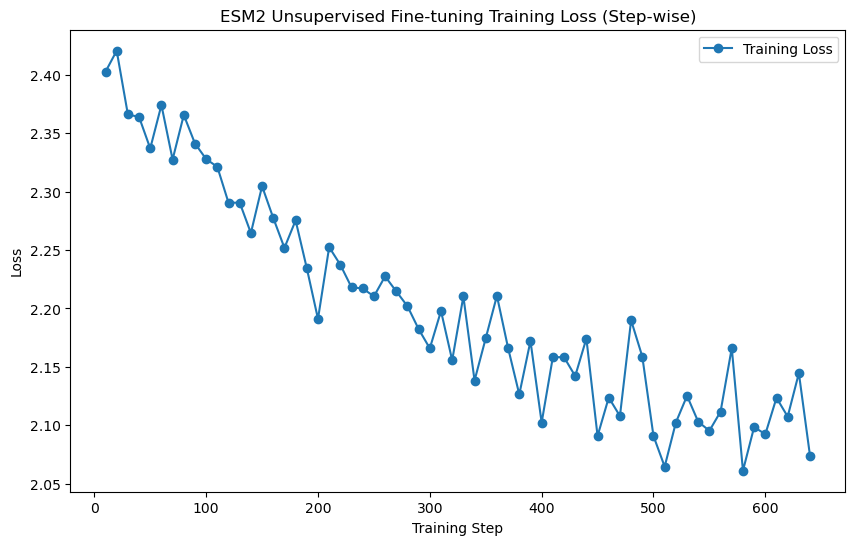

In [ ]:
# Plot training loss

import matplotlib.pyplot as plt

def plot_training_loss(log_history, x_axis='step', output_path=None):
    """
    Plots the training loss from Trainer's log_history.
    
    Args:
        log_history (list): The trainer.state.log_history list of dictionaries.
        x_axis (str): 'step' or 'epoch' — determines x-axis.
        output_path (str, optional): Path to save the plot.
    """
    # Filter for training logs with 'loss' (but not 'eval_loss')
    train_logs = [entry for entry in log_history if 'loss' in entry and 'eval_loss' not in entry]

    if x_axis not in {'step', 'epoch'}:
        raise ValueError("x_axis must be either 'step' or 'epoch'.")

    x_values = [entry.get(x_axis, None) for entry in train_logs]
    y_values = [entry['loss'] for entry in train_logs]

    # Filter out entries where x_axis wasn't recorded
    x_values, y_values = zip(*[(x, y) for x, y in zip(x_values, y_values) if x is not None])

    if not x_values:
        print(f"No valid '{x_axis}' data found in history to plot.")
        return

    plt.figure(figsize=(10, 6))
    plt.plot(x_values, y_values, marker='o', label='Training Loss')
    plt.xlabel('Epoch' if x_axis == 'epoch' else 'Training Step')
    plt.ylabel('Loss')
    plt.title(f"ESM2 Unsupervised Fine-tuning Training Loss ({x_axis.capitalize()}-wise)")
    plt.grid(False)
    plt.legend()

    if output_path:
        #plt.savefig(output_path)
        print(f"Training loss plot saved to {output_path}")
    else:
        plt.show()

plot_training_loss(history, x_axis='step')  # or 'epoch'


### Use model after fine-tuning

In [ ]:
import sys
from enzymetk.embedprotein_esm_step import EmbedESM
from enzymetk.save_step import Save
import pandas as pd

# run in enzymetk environemnt
id_col = 'UniprotID'
seq_col = 'sequence'
output_dir = 'esm2/'

df_test << (EmbedESM(id_col, seq_col, extraction_method='mean', tmp_dir=output_dir) >> Save(f'{output_dir}df_test_esm2.pkl'))

In [10]:
import pandas as pd
import torch
from transformers import AutoTokenizer, EsmForMaskedLM
from tqdm import tqdm

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("./fine_tuned_esm2_esterase_mlm")
model = EsmForMaskedLM.from_pretrained("./fine_tuned_esm2_esterase_mlm")
model.eval()

# Optional: use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to compute mean-pooled embedding for one sequence
def embed_sequence(sequence):
    inputs = tokenizer(sequence, return_tensors="pt", add_special_tokens=True, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.esm(**inputs)
        embeddings = outputs.last_hidden_state
        mask = inputs["attention_mask"].unsqueeze(-1)
        masked_embeddings = embeddings * mask
        pooled = masked_embeddings.sum(dim=1) / mask.sum(dim=1)
    return pooled.squeeze().cpu().numpy()

# Apply to DataFrame
sequence_embeddings = []
for seq in tqdm(df_test["sequence"], desc="Embedding sequences"):
    embedding = embed_sequence(seq)
    sequence_embeddings.append(embedding)

# Save embeddings to a new column or separate file
df_test = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/esm2/df_test_esm2.pkl')
df_test["finetuned_esm2_embedding"] = sequence_embeddings


Some weights of EsmForMaskedLM were not initialized from the model checkpoint at ./fine_tuned_esm2_esterase_mlm and are newly initialized: ['esm.embeddings.position_embeddings.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Embedding sequences: 100%|██████████| 1050/1050 [00:07<00:00, 139.24it/s]


### Fine-tuning using LoRA

In [ ]:
from peft import LoraConfig, get_peft_model

def load_esm_model(checkpoint, unfrozen_layers=0, use_lora=True):
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    model = EsmForMaskedLM.from_pretrained(checkpoint)

    if use_lora:
        peft_config = LoraConfig(
            r=4,
            lora_alpha=16,
            target_modules=["query", "key", "value", "dense"],  # Customize based on model architecture
            lora_dropout=0.1,
            bias="none",
            task_type="CAUSAL_LM"  # or "SEQ_2_SEQ_LM" depending on your model type
        )
        model = get_peft_model(model, peft_config)
        print("LoRA adapters injected.")

        # Freeze all parameters except LoRA layers
        for name, param in model.named_parameters():
            if 'lora' not in name and 'lm_head' not in name:
                param.requires_grad = False
            else:
                print(f"Training parameter: {name}")
    else:
        # If not using LoRA, freeze layers except last `unfrozen_layers` and lm_head
        num_encoder_layers = model.esm.encoder.config.num_hidden_layers
        for i, layer in enumerate(model.esm.encoder.layer):
            if i < num_encoder_layers - unfrozen_layers:
                for param in layer.parameters():
                    param.requires_grad = False
            else:
                print(f"Layer {i} (0-indexed) will be trained.")
        for param in model.lm_head.parameters():
            param.requires_grad = True
        print("LM Head will be trained.")
    
    return model, tokenizer


def train_per_protein(
        checkpoint,
        output_dir,
        train_df,
        batch=4,
        accum=2,
        val_batch=16,
        epochs=10,
        lr=1e-3,
        seed=42,
        deepspeed=False,
        mixed=True,
        full=False,
        gpu=1,
        use_lora=True  # Add this flag
    ):

    print("Model used:", checkpoint, "\n")
    set_seeds(seed)

    # Load model with LoRA if enabled
    model, tokenizer = load_esm_model(checkpoint, unfrozen_layers=0, use_lora=use_lora)

    train_df["sequence"] = train_df["sequence"].str.replace('|'.join(["O","B","U","Z","J"]), "X", regex=True)
    train_set = create_dataset(tokenizer, list(train_df['sequence']))

    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=True,
        num_train_epochs=epochs,
        per_device_train_batch_size=batch,
        gradient_accumulation_steps=accum,
        save_steps=10_000,
        save_total_limit=2,
        prediction_loss_only=True,
        logging_dir='./logs',
        logging_steps=100,
        report_to="none",
        dataloader_num_workers=2,
        fp16=mixed,
        predict_with_generate=False,
        # Add deepspeed config if needed here
    )

    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=True,
        mlm_probability=0.15
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_set,
        tokenizer=tokenizer,
        data_collator=data_collator
    )

    print("\nStarting fine-tuning...")
    trainer.train()

    # Save the fine-tuned model
    model.save_pretrained("./fine_tuned_esm2_esterase_mlm")
    tokenizer.save_pretrained("./fine_tuned_esm2_esterase_mlm")

    print(f"Fine-tuned model and tokenizer saved to {output_dir}")


    # Save the PEFT adapters (LoRA weights)
    if use_lora:
        model.save_pretrained(output_dir)
        print(f"LoRA adapters saved to {output_dir}")

    return tokenizer, model, trainer.state.log_history


In [15]:
tokenizer, model, log_history = train_per_protein(
    checkpoint=checkpoint,
    output_dir=output_dir,
    train_df=df_train,
    batch=8,
    accum=1,
    epochs=5,
    lr=1e-3,
    seed=42,
    use_lora=True  # Enable LoRA fine-tuning
)

Model used: facebook/esm2_t6_8M_UR50D 



Some weights of the model checkpoint at facebook/esm2_t6_8M_UR50D were not used when initializing EsmForMaskedLM: ['esm.embeddings.position_embeddings.weight']
- This IS expected if you are initializing EsmForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


AttributeError: 'EsmForMaskedLM' object has no attribute 'prepare_inputs_for_generation'

## Analysis of fine-tuned embeddings

### PCA of ESM2 embeddings before and after fine-tuning

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_pca_embeddings(df, embedding_col_before='embedding_before', embedding_col_after='embedding_after', ec_column='EC number', ec_level=3):
    # Extract EC class prefix
    df['EC_prefix'] = df[ec_column].apply(
        lambda x: '.'.join(x.split('.')[:ec_level]) if isinstance(x, str) else 'Unknown'
    )

    # Convert embeddings to arrays
    embeddings_before = np.vstack(df[embedding_col_before].values)
    embeddings_after = np.vstack(df[embedding_col_after].values)

    # Combine for shared PCA space
    combined_embeddings = np.vstack([embeddings_before, embeddings_after])
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(combined_embeddings)

    # Split back
    reduced_before = reduced[:len(df)]
    reduced_after = reduced[len(df):]

    # Setup plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

    unique_ecs = sorted(df['EC_prefix'].unique())
    color_map = {ec: plt.cm.tab20(i % 20) for i, ec in enumerate(unique_ecs)}

    def scatter(ax, reduced_data, title):
        for ec in unique_ecs:
            idxs = df[df['EC_prefix'] == ec].index
            ax.scatter(reduced_data[idxs, 0], reduced_data[idxs, 1],
                       label=ec, alpha=0.7, s=40, color=color_map[ec])
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')

    scatter(axes[0], reduced_before, 'Before Fine-Tuning')
    scatter(axes[1], reduced_after, 'After Fine-Tuning')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=f'EC (First {ec_level} digits)')
    plt.tight_layout()
    plt.show()


plot_pca_embeddings(df_test, embedding_col_before='embedding',
                    embedding_col_after='finetuned_esm2_embedding', ec_column='EC number')


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1280 and the array at index 1 has size 320

In [12]:
df_test

,UniprotID,RHEA_ID,DIRECTION,MASTER_ID,SMILES,EC number,CANO_RXN_SMILES,sequence,reverse_template,n_seq,...,number_substrates,number_products,atom_mapped_SMILES,cleaved_substrate,mmseqs2_clusters_0p95_similarity,mmseqs_representative_cluster_seq_0p5_similarity,mmseqs_representative_cluster_seq_0p3_similarity,embedding,finetuned_esm2_embedding,EC_prefix
0,A0A0G2JXT6,45632,UN,45632,CCCCCCCC(=O)OC[C@H](COP(=O)([O-])O[C@@H]1[C@H]...,3.1.3.95,CCCCCCCC(=O)OC[C@H](COP(=O)(O)O[C@@H]1[C@H](O)...,MEHIRTTKVEQVKLLDRFSTNNKSLTGTLYLTATHLLFIDAHQKET...,[C:1]-[OH;D1;+0:2].[O;-;D1;H0:4]-[P;H0;D4;+0:3...,655,...,2,2,[CH3:1][CH2:2][CH2:3][CH2:4][CH2:5][CH2:6][CH2...,CCCCCCCC(=O)OC[C@H](COP(=O)([O-])O[C@@H]1[C@H]...,A0A0G2JXT6,Q96EF0,Q96EF0,"[0.01086533, -0.036436066, 0.023325494, 0.0449...","[-0.1378907, -0.23560806, 0.15125439, 0.072636...",3.1.3
1,A0A0G2JXT6,39019,UN,39019,*C(=O)OC[C@]([H])(COP(=O)([O-])O[C@@H]1[C@H](O...,3.1.3.95,*C(=O)OC[C@H](COP(=O)(O)O[C@@H]1[C@H](O)[C@H](...,MEHIRTTKVEQVKLLDRFSTNNKSLTGTLYLTATHLLFIDAHQKET...,[C:1]-[OH;D1;+0:2].[O;-;D1;H0:4]-[P;H0;D4;+0:3...,655,...,2,2,[*:1][C:2](=[O:3])[O:4][CH2:5][C@H:6]([CH2:7][...,*C(=O)OC[C@H](COP(=O)([O-])O[C@@H]1[C@H](O)[C@...,A0A0G2JXT6,Q96EF0,Q96EF0,"[0.01086533, -0.036436066, 0.023325494, 0.0449...","[-0.1378907, -0.23560806, 0.15125439, 0.072636...",3.1.3
2,A0A0G2JXT6,12316,UN,12316,*C(=O)OC[C@]([H])(COP(=O)([O-])O[C@@H]1[C@H](O...,3.1.3.95,*C(=O)OC[C@H](COP(=O)(O)O[C@@H]1[C@H](O)[C@H](...,MEHIRTTKVEQVKLLDRFSTNNKSLTGTLYLTATHLLFIDAHQKET...,[C:1]-[OH;D1;+0:2].[O;-;D1;H0:4]-[P;H0;D4;+0:3...,655,...,2,2,[*:1][C:2](=[O:3])[O:4][CH2:5][C@H:6]([CH2:7][...,*C(=O)OC[C@H](COP(=O)([O-])O[C@@H]1[C@H](O)[C@...,A0A0G2JXT6,Q96EF0,Q96EF0,"[0.01086533, -0.036436066, 0.023325494, 0.0449...","[-0.1378907, -0.23560806, 0.15125439, 0.072636...",3.1.3
3,A0A0G2JXT6,42328,UN,42328,CCCCCCCC(=O)OC[C@H](COP(=O)([O-])O[C@@H]1[C@H]...,3.1.3.95,CCCCCCCC(=O)OC[C@H](COP(=O)(O)O[C@@H]1[C@H](O)...,MEHIRTTKVEQVKLLDRFSTNNKSLTGTLYLTATHLLFIDAHQKET...,[C:1]-[OH;D1;+0:2].[O;-;D1;H0:4]-[P;H0;D4;+0:3...,655,...,2,2,[CH3:1][CH2:2][CH2:3][CH2:4][CH2:5][CH2:6][CH2...,CCCCCCCC(=O)OC[C@H](COP(=O)([O-])O[C@@H]1[C@H]...,A0A0G2JXT6,Q96EF0,Q96EF0,"[0.01086533, -0.036436066, 0.023325494, 0.0449...","[-0.1378907, -0.23560806, 0.15125439, 0.072636...",3.1.3
32,A0A1W2PQ27,47004,UN,47004,*N[C@H](C(*)=O)[C@@H](C)OP(=O)([O-])[O-],3.1.3.16,*N[C@H](C(*)=O)[C@@H](C)OP(=O)(O)O.O>>*N[C@H](...,MLSSTLRVAVVCVSNVNRSMEAHSILRRKGLSVRSFGTESHVRLPG...,[C:1]-[OH;D1;+0:2].[O-;H0;D1:7]-[P;H0;D4;+0:3]...,194,...,2,2,[*:1][NH:2][C@H:3]([C:4]([*:5])=[O:6])[C@@H:7]...,*N[C@H](C(*)=O)[C@@H](C)OP(=O)([O-])[O-],A0A1W2PQ27,A0A1W2PQ27,Q75E60,"[0.02401515, -0.013343554, -0.019602224, 0.033...","[-0.12774202, -0.3660567, -0.040087312, -0.002...",3.1.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4868,Q9ZSE4,47004,UN,47004,*N[C@H](C(*)=O)[C@@H](C)OP(=O)([O-])[O-],3.1.3.16,*N[C@H](C(*)=O)[C@@H](C)OP(=O)(O)O.O>>*N[C@H](...,MPSHGDLDRQIEHLMECKPLPEARGQTLCDQARAILVEEWNVQPVK...,[C:1]-[OH;D1;+0:2].[O-;H0;D1:7]-[P;H0;D4;+0:3]...,306,...,2,2,[*:1][NH:2][C@H:3]([C:4]([*:5])=[O:6])[C@@H:7]...,*N[C@H](C(*)=O)[C@@H](C)OP(=O)([O-])[O-],Q9ZSE4,P23595,Q7YSW8,"[0.019048914, -0.01037401, 0.010033733, -0.024...","[0.0030942152, -0.39005366, 0.12748566, 0.0622...",3.1.3
4869,Q9ZSE4,20629,UN,20629,*N[C@@H](COP(=O)([O-])[O-])C(*)=O,3.1.3.16,*N[C@@H](COP(=O)(O)O)C(*)=O.O>>*N[C@@H](CO)C(*...,MPSHGDLDRQIEHLMECKPLPEARGQTLCDQARAILVEEWNVQPVK...,NaN,306,...,2,2,[*:1][NH:2][C@@H:3]([CH2:4][O:5][P:10](=[O:9])...,*N[C@@H](COP(=O)([O-])[O-])C(*)=O,Q9ZSE4,P23595,Q7YSW8,"[0.019048914, -0.01037401, 0.010033733, -0.024...","[0.0030942152, -0.39005366, 0.12748566, 0.0622...",3.1.3
4880,V6CIV8,10684,UN,10684,*N[C@@H](CC1=CC=C(OP(=O)([O-])[O-])C=C1)C(*)=O,3.1.3.16; 3.1.3.48,*N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(*)=O.O>>*N[C@...,MTTHLPSTSQNGEEISAEQFNRIFHERNVIVLDCRSNGDSVKRANR...,[O-;H0;D1:7]-[P;H0;D4;+0:2](-[O;-;D1;H0:3])(=[...,381,...,2,2,[*:1][NH:2][C@@H:3]([CH2:4][c:5]1

### Prediction of EC classes using CLEAN